In [19]:
!pip install pulp scipy matplotlib deap

[1, 2] [1, 2, 3] {1: 70, 2: 94} {1: 48, 2: 23, 3: 67} {(1, 1): 76, (1, 2): 57, (1, 3): 14, (2, 1): 50, (2, 2): 73, (2, 3): 97}
[1, 2, 3, 4, 5] [1, 2, 3, 4, 5, 6] {1: 80, 2: 82, 3: 77, 4: 89, 5: 87} {1: 10, 2: 82, 3: 71, 4: 99, 5: 85, 6: 25} {(1, 1): 90, (1, 2): 17, (1, 3): 62, (1, 4): 92, (1, 5): 70, (1, 6): 20, (2, 1): 60, (2, 2): 17, (2, 3): 18, (2, 4): 78, (2, 5): 89, (2, 6): 12, (3, 1): 23, (3, 2): 15, (3, 3): 41, (3, 4): 96, (3, 5): 50, (3, 6): 27, (4, 1): 16, (4, 2): 91, (4, 3): 90, (4, 4): 94, (4, 5): 22, (4, 6): 95, (5, 1): 99, (5, 2): 16, (5, 3): 14, (5, 4): 60, (5, 5): 16, (5, 6): 17}
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] {1: 82, 2: 56, 3: 67, 4: 56, 5: 101, 6: 97, 7: 58, 8: 94, 9: 117, 10: 149} {1: 90, 2: 21, 3: 29, 4: 98, 5: 86, 6: 71, 7: 47, 8: 75, 9: 77, 10: 86, 11: 15, 12: 98} {(1, 1): 29, (1, 2): 16, (1, 3): 58, (1, 4): 68, (1, 5): 67, (1, 6): 12, (1, 7): 34, (1, 8): 80, (1, 9): 46, (1, 10): 15, (1, 11): 15, (1, 12): 92, (2, 1): 65, (2,

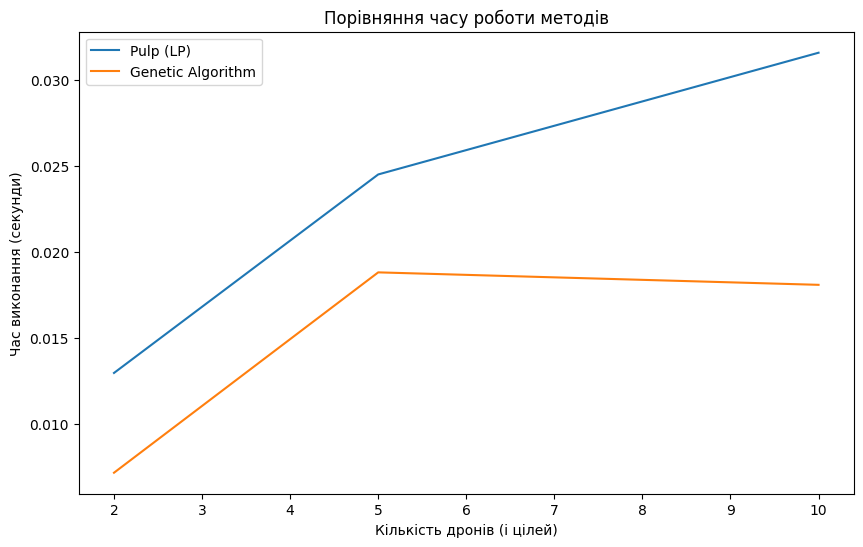

Таблиця порівняння часу виконання:
  Кількість дронів/цілей  Pulp (LP) час, сек  Genetic час, сек
0                    2/3            0.012945          0.007137
1                    5/6            0.024501          0.018800
2                  10/12            0.031587          0.018075


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpBinary, value
from scipy.optimize import minimize
import random

drones_list = [2, 5, 10]
targets_list = [3, 6, 12]
results = {"pulp": [], "genetic": []}


def run_pulp(drones, targets, fuel, priority, distance):
    start_time = time.time()
    model = LpProblem("Drone_Target_Assignment", LpMaximize)
    x = LpVariable.dicts("assign", (drones, targets), cat=LpBinary)
    model += lpSum(priority[j] * x[i][j] for i in drones for j in targets)

    for i in drones:
        model += lpSum(x[i][j] for j in targets) <= 1
    for j in targets:
        model += lpSum(x[i][j] for i in drones) <= 1
    for i in drones:
        for j in targets:
            model += distance[(i, j)] * x[i][j] <= fuel[i]
    model.solve()
    return time.time() - start_time

def run_genetic(drones, targets, fuel, priority, distance):
    start_time = time.time()
    population_size = 20
    generations = 50
    mutation_rate = 0.1

    def initialize_population():
        population = []
        for _ in range(population_size):
            individual = []
            for i in range(len(drones)):
                assignment = [0] * len(targets)
                assigned_target = np.random.choice(range(len(targets)))
                assignment[assigned_target] = 1
                individual.append(assignment)
            population.append(individual)
        return population

    def fitness(solution):
        total_priority = 0
        for j in range(len(targets)):
            if sum(solution[i][j] for i in range(len(drones))) > 1:
                return 0
        for i, drone in enumerate(drones):
            assigned = False
            for j, target in enumerate(targets):
                if solution[i][j] == 1:
                    if distance[(drone, target)] <= fuel[drone]:
                        total_priority += priority[target]
                        assigned = True
                    else:
                        return 0
            if not assigned:
                return 0
        return total_priority

    population = initialize_population()
    best_fitness = 0
    for generation in range(generations):
        population_fitness = [fitness(individual) for individual in population]
        max_fitness = max(population_fitness)
        if max_fitness > best_fitness:
            best_fitness = max_fitness
        new_population = []
        for _ in range(population_size // 2):
            parent1 = random.choice(population)
            parent2 = random.choice(population)
            child1 = parent1.copy()
            child2 = parent2.copy()
            new_population.extend([child1, child2])
        population = new_population
    return time.time() - start_time

for drones_count, targets_count in zip(drones_list, targets_list):
    drones = list(range(1, drones_count + 1))
    targets = list(range(1, targets_count + 1))
    fuel = {d: np.random.randint(50, 150) for d in drones}
    priority = {t: np.random.randint(10, 100) for t in targets}
    distance = {(d, t): np.random.randint(10, 100) for d in drones for t in targets}

    print(drones, targets, fuel, priority, distance)

    results["pulp"].append(run_pulp(drones, targets, fuel, priority, distance))
    results["genetic"].append(run_genetic(drones, targets, fuel, priority, distance))

plt.figure(figsize=(10, 6))
plt.plot(drones_list, results["pulp"], label="Pulp (LP)")
plt.plot(drones_list, results["genetic"], label="Genetic Algorithm")
plt.xlabel("Кількість дронів (і цілей)")
plt.ylabel("Час виконання (секунди)")
plt.title("Порівняння часу роботи методів")
plt.legend()
plt.show()

comparison_table = pd.DataFrame({
    "Кількість дронів/цілей": [f"{d}/{t}" for d, t in zip(drones_list, targets_list)],
    "Pulp (LP) час, сек": results["pulp"],
    "Genetic час, сек": results["genetic"]
})

print("Таблиця порівняння часу виконання:")
print(comparison_table)